In [13]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_theme(style="whitegrid", palette="muted")
plt.rc('patch', edgecolor='black')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})

In [14]:
df = pd.read_csv('/Users/rafiquaferdousi/Documents/GitHub/A-B-testing-repo/A/ab_data.csv')

In [15]:
df.sample(10)

,user_id,timestamp,group,landing_page,converted
79535,829326,2017-01-03 01:23:29.049554,control,old_page,0
35192,784895,2017-01-21 04:50:38.578526,control,old_page,0
1939,719886,2017-01-18 11:32:18.330178,control,old_page,0
225784,814869,2017-01-08 18:19:45.353489,treatment,new_page,0
34427,744645,2017-01-14 01:55:46.893825,treatment,new_page,0
205720,867318,2017-01-23 04:58:53.085216,control,old_page,0
101360,800295,2017-01-18 18:32:17.801818,treatment,new_page,0
215049,807682,2017-01-04 15:26:07.485836,treatment,new_page,0
134984,809539,2017-01-03 22:41:41.879769,treatment,new_page,0
195519,895487,2017-01-03 00:46:20.062524,control,old_page,0


In [16]:
df.shape

(294478, 5)

In [17]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [18]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [20]:
df.columns.tolist()

['user_id', 'timestamp', 'group', 'landing_page', 'converted']

In [21]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [22]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.9,  #power of a test (defualt is 0.8)
    alpha=0.05, #p-value
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

5934


In [23]:
df[['user_id', 'timestamp']].nunique()

user_id      290584
timestamp    294478
dtype: int64

In [24]:
df.user_id.value_counts()

805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: user_id, Length: 290584, dtype: int64

In [25]:
session_counts = df.user_id.value_counts()
double_users = session_counts[session_counts>1].index

double_users

Int64Index([805339, 754884, 722274, 783176, 898232, 899018, 904570, 842042,
            881123, 858720,
            ...
            721188, 902463, 713355, 827417, 655283, 847058, 889392, 664150,
            835401, 736955],
           dtype='int64', length=3894)

In [26]:
df['user_id'].isin(double_users).value_counts()

False    286690
True       7788
Name: user_id, dtype: int64

In [27]:
df = df[~df['user_id'].isin(double_users)]
df.shape

(286690, 5)

In [28]:
control_group = df.query('group == "control"').sample(required_n)
treatment_group = df.query('group == "treatment"').sample(required_n)

In [29]:
control_group.head()

,user_id,timestamp,group,landing_page,converted
4378,679514,2017-01-22 13:12:05.062301,control,old_page,0
69390,860251,2017-01-06 02:10:40.059521,control,old_page,0
53358,633983,2017-01-04 14:28:47.605884,control,old_page,0
75062,764961,2017-01-13 15:14:23.117644,control,old_page,0
59428,824433,2017-01-22 06:46:33.596204,control,old_page,0


In [30]:
treatment_group.head()

,user_id,timestamp,group,landing_page,converted
85747,893011,2017-01-07 15:39:09.072618,treatment,new_page,0
2736,765562,2017-01-23 23:47:13.757124,treatment,new_page,0
173459,859216,2017-01-20 22:47:03.843107,treatment,new_page,1
274705,662320,2017-01-16 10:30:43.694691,treatment,new_page,0
202371,929727,2017-01-04 11:07:45.214280,treatment,new_page,0


In [31]:
ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(inplace=True, drop=True)

In [32]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11868 entries, 0 to 11867
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       11868 non-null  int64 
 1   timestamp     11868 non-null  object
 2   group         11868 non-null  object
 3   landing_page  11868 non-null  object
 4   converted     11868 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 463.7+ KB


In [33]:
ab_test.group.value_counts()

control      5934
treatment    5934
Name: group, dtype: int64

In [34]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.004
treatment,0.119,0.324,0.004


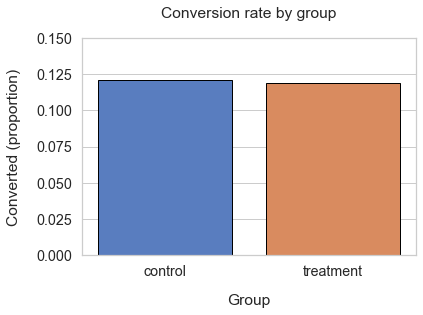

In [35]:
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);